# Melanoma, Fundoscopy - InceptionV3
-----------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import torch
import torchvision
from torchvision import transforms, models
from torch import nn, optim
import torch.nn.functional as F
import sklearn.metrics as metrics

print("Do you want to run the training process? (y / n)")
i = input()
if i == 'y':
    train_model = True
else:
    train_model = False
    
fpath = "/home/arttu/Documents/research/melanoma/"
# fpath = "hakkina7@triton.aalto.fi:/scratch/work/hakkina7/research/melanoma/"
print("File path is {}".format(fpath))

# Set the device
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
print("Device is {}".format(device))

# Set file name
fname = 'inceptionV3.pth'

Do you want to run the training process? (y / n)
y
File path is /home/arttu/Documents/research/melanoma/
Device is cpu


## Data preprocessing
--------------

### Important: In contrast to the other models the inception_v3 expects tensors with a size of N x 3 x 299 x 299, so ensure your images are sized accordingly.

Show some images? (y / n)
y
tensor([5, 5, 4, 5, 5, 6, 5, 4, 0])


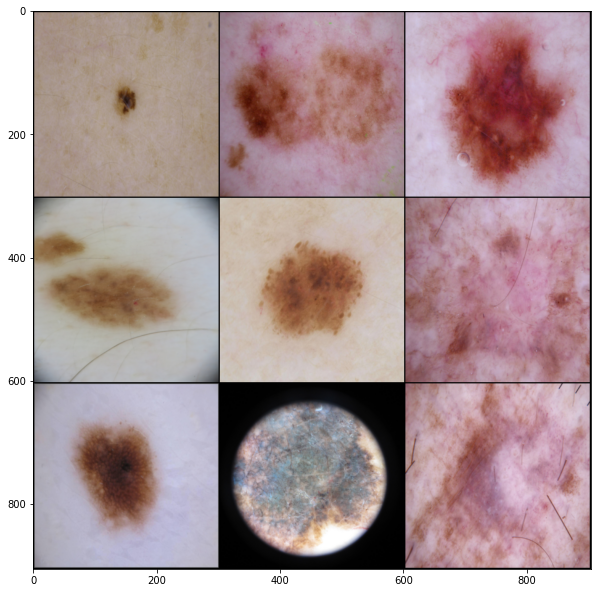

In [2]:
# Takes a while to run the mean and std calculation, so save the values here
# NB: These have to be calculated again if the image size is changed
# NB: Modifying the batch size doesn't matter, mean and std stay the same
# mean = [0.485, 0.456, 0.406] # https://pytorch.org/hub/pytorch_vision_inception_v3/
# std = [0.229, 0.224, 0.225] # https://pytorch.org/hub/pytorch_vision_inception_v3/

h, w = (299, 299)
# Get proper dataloader with normalized images
transformations = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([1.0, 1.0, 1.0]))
])

trainset = torchvision.datasets.ImageFolder(root=fpath+"data/train/",
                                           transform=transformations)
testset = torchvision.datasets.ImageFolder(root=fpath+"data/test/",
                                           transform=transformations)
valset = torchvision.datasets.ImageFolder(root=fpath+"data/val/",
                                           transform=transformations)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=8, shuffle=False)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=5, shuffle=False)

print("Show some images? (y / n)")
i = input()
if i == 'y':
    show = True
else:
    show = False

if show:
    # Show some images after transformations
    loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=9, shuffle=True)
    images, labels = next(iter(loader))
    grid=torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(10,40))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print(labels)

## Training
--------------

In [4]:
def train(model, epochs, trainloader, testloader, device, optimizer, loss_fn, weights):
    """Training loop"""
    
    for epoch in range(epochs):
        model.train()
        best_acc = 0
        losses = []
        correct = 0
        total = 0
        start = time.time()
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            _, pred = torch.max(outputs, 1)
            correct += (labels == pred).sum().item()
            total += labels.size(0)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            print("Batch {}/{}: {:.2f} seconds".format(i+1, len(trainloader), time.time()-start))
            start=time.time()
        acc = 100 * correct/total
        print("\nEpoch {}:\nMean loss {} - Correctly labeled training images {:.2f}%".format(epoch+1,
                                                                                           np.mean(losses),
                                                                                           acc))
        
        model.eval()
        correct = 0
        total = 0
        true = torch.zeros(0, dtype=torch.long, device='cpu')
        preds = torch.zeros(0, dtype=torch.long, device='cpu')
        probs = torch.zeros(0, dtype=torch.float, device='cpu')
        with torch.no_grad():
            start = time.time()
            for i, (images, labels) in enumerate(testloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, pred = torch.max(outputs, 1)
                correct += (pred == labels).sum().item()
                total += labels.size(0)
                true = torch.cat([true, labels.view(-1)])
                preds = torch.cat([preds, pred.view(-1)])
                prob, _ = (F.softmax(outputs, dim=1)).topk(1, dim=1)
                probs = torch.cat([probs, prob.view(-1)])
                print("Batch {}/{}: {:.2f} seconds".format(i+1, len(testloader), time.time()-start))
                start=time.time()
                
        acc = 100 * correct/total
        print("Classified {:.2f} % of test images correctly.".format(
            acc
        ))
        print("Precision on test set: {}".format(
            metrics.precision_score(true.numpy(),
                                    preds.numpy(),
                                    average=None)
        ))
        print("Recall on test set: {}".format(
            metrics.recall_score(true.numpy(),
                                 preds.numpy(), 
                                 average=None)
        ))
        print("F1-score on test set: {}".format(
            metrics.f1_score(true.numpy(),
                             preds.numpy(),
                             average=None)
        ))
        classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
        aucs = {}
        for i, c in enumerate(classes):
            fpr, tpr, _ = metrics.roc_curve(true.numpy(),
                                            probs.numpy(), 
                                            pos_label=i)
            aucs[c] = metrics.auc(fpr, tpr)
        print("ROC AUC on test set: {}".format(aucs))
        print("Confusion matrix on test set:")
        print(pd.DataFrame(metrics.confusion_matrix(true.numpy(), preds.numpy()), 
                           columns=['pred as AK', 'pred as BCC', 
                                    'pred as BKL', 'pred as DF',
                                    'pred as MEL', 'pred as NV',
                                    'pred as SCC', 'pred as VASC'], 
                           index=['true class AK', 'true class BCC',
                                  'true class BKL', 'true class DF',
                                  'true class MEL', 'true class NV',
                                  'true class SCC', 'true class VASC']))
        print()

    print("Training finished.")

    return model


if train_model:
    print("Training InceptionV3 model for Fundoscopy classification task.")
    
    # Initialize the model
    model = models.inception_v3(pretrained=False)
    n_labels = 8
    n_inputs = model.fc.in_features
    model.fc = nn.Linear(n_inputs, n_labels)
    model = model.to(device)
    
    # Calculate weights for the weighted loss function. We need the weighted loss,
    # because of the class imbalance that is present on the data sets. If
    # weighted loss fails, try focal loss with alpha=0.25 and gamma=2.
    n_samples = [694, 2658, 2099, 191, 3618, 10300, 502, 202]
    weights = [1 / (x / sum(n_samples)) for x in n_samples]  # More weight on the samples that appear less
    weights = torch.FloatTensor(weights).to(device)
    print("Since there is class imbalance present in some of the data sets, use the following weights in the loss function:")
    print(weights)
    print()
    
    # Train model
    model = train(model=model,
                  epochs=100,
                  trainloader=trainloader,
                  testloader=testloader,
                  device=device,
                  optimizer=optim.SGD(list(model.parameters()),
                                      lr=1e-3,
                                      momentum=0.9),
                  loss_fn=nn.CrossEntropyLoss(weight=weights),
                  weights=weights)
    
    # Save the trained model
    torch.save(model.state_dict(), fpath+fname)
    print("Model succesfully saved to {}".format(fpath+fname))

Training InceptionV3 model for Fundoscopy classification task.
Since there is class imbalance present in some of the data sets, use the following weights in the loss function:
tensor([ 29.1988,   7.6238,   9.6541, 106.0942,   5.6009,   1.9674,  40.3665,
        100.3168])

Batch 1/634: 12.44 seconds
Batch 2/634: 13.84 seconds


KeyboardInterrupt: 

## Evaluate
---------------

In [ ]:
def evaluate(model, valloader, device):
    """Evaluate model performance on validation set"""
    
    model.eval()
    correct = 0
    total = 0
    true = torch.zeros(0, dtype=torch.long, device='cpu')
    preds = torch.zeros(0, dtype=torch.long, device='cpu')
    probs = torch.zeros(0, dtype=torch.float, device='cpu')
    with torch.no_grad():
        start = time.time()
        for i, (images, labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            true = torch.cat([true, labels.view(-1)])
            preds = torch.cat([preds, pred.view(-1)])
            prob, _ = (F.softmax(outputs, dim=1)).topk(1, dim=1)
            probs = torch.cat([probs, prob.view(-1)])
            print("Batch {}/{}: {:.2f} seconds".format(i+1, len(valloader), time.time()-start))
            start=time.time()
    
    acc = 100 * correct/total
    print("Classified {:.2f} % of validation images correctly.".format(
        acc
    ))
    print("Precision on validation set: {}".format(
        metrics.precision_score(true.numpy(),
                                preds.numpy(),
                                average=None)
    ))
    print("Recall on validation set: {}".format(
        metrics.recall_score(true.numpy(),
                             preds.numpy(), 
                             average=None)
    ))
    print("F1-score on validation set: {}".format(
        metrics.f1_score(true.numpy(),
                         preds.numpy(),
                         average=None)
    ))
    classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
    aucs = {}
    for i, c in enumerate(classes):
        fpr, tpr, _ = metrics.roc_curve(true.numpy(),
                                        probs.numpy(), 
                                        pos_label=i)
        aucs[c] = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} AUC = {:.2f}'.format(c, metrics.auc(fpr, tpr)))
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("ROC AUC on validation set: {}".format(aucs))
    print("Confusion matrix on validation set:")
    print(pd.DataFrame(metrics.confusion_matrix(true.numpy(), preds.numpy()), 
                       columns=['pred as AK', 'pred as BCC', 
                                'pred as BKL', 'pred as DF',
                                'pred as MEL', 'pred as NV',
                                'pred as SCC', 'pred as VASC'], 
                       index=['true class AK', 'true class BCC',
                              'true class BKL', 'true class DF',
                              'true class MEL', 'true class NV',
                              'true class SCC', 'true class VASC']))
    print()
    

# Initialize model
model = models.inception_v3(pretrained=False)
n_labels = 8
n_inputs = model.fc.in_features
model.fc = nn.Linear(n_inputs, n_labels)

# Load model params
if torch.cuda.is_available():
    model.load_state_dict(torch.load(fpath+fname))
    model.to(device)
else:
    model.load_state_dict(torch.load(fpath+fname,
                                     map_location=torch.device('cpu')))
    
print("Model succesfully loaded from {}".format(fpath+fname))

# Evaluate the model performance on validation set
print("Evaluating the InceptionV3 model on the validation set.")
evaluate(model, valloader, device)